In [1]:
%tensorflow_version 1.x

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise, RepeatVector, Permute
from keras.layers import GRU, Bidirectional, TimeDistributed, Multiply, Lambda, GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 200

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENT_LENGTH = 500
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [0]:
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [0]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

CPU times: user 17.7 s, sys: 294 ms, total: 18 s
Wall time: 18.1 s


In [0]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

CPU times: user 306 ms, sys: 1.08 ms, total: 307 ms
Wall time: 308 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load("/content/drive/My Drive/Colab Notebooks/w2v2_modregex_200.w2v")

2020-05-10 11:47:00,517 : INFO : loading Word2Vec object from /content/drive/My Drive/Colab Notebooks/w2v2_modregex_200.w2v
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-05-10 11:47:01,586 : INFO : loading wv recursively from /content/drive/My Drive/Colab Notebooks/w2v2_modregex_200.w2v.wv.* with mmap=None
2020-05-10 11:47:01,587 : INFO : loading vectors from /content/drive/My Drive/Colab Notebooks/w2v2_modregex_200.w2v.wv.vectors.npy with mmap=None
2020-05-10 11:47:07,967 : INFO : setting ignored attribute vectors_norm to None
2020-05-10 11:47:07,969 : INFO : loading vocabulary recursively from /content/drive/My Drive/Colab Notebooks/w2v2_modregex_200.w2v.vocabulary.* with mmap

In [11]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 152070


In [12]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 264006
CPU times: user 53 s, sys: 41.1 ms, total: 53.1 s
Wall time: 53.1 s


In [13]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=MAX_SENT_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=MAX_SENT_LENGTH)

CPU times: user 52.3 s, sys: 650 ms, total: 53 s
Wall time: 53 s


In [14]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(np.asarray(df_train.target))
y_test = to_categorical(np.asarray(df_test.target))


print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (650000, 5)
y_test (50000, 5)


In [0]:
word_index = tokenizer.word_index

# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH, trainable=False, name='Embedding')

In [16]:
input_layer = Input(shape=(MAX_SENT_LENGTH,), name = 'Input')
embedded_layer = embedding_layer(input_layer)

conv1 = Conv1D(200, 3, activation='relu')(embedded_layer)
conv2 = Conv1D(200, 4, activation='relu')(embedded_layer)
conv3 = Conv1D(200, 5, activation='relu')(embedded_layer)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

conc_layer = concatenate([pool3, pool2, pool1])
drop1 = Dropout(0.5)(conc_layer)
fc_layer1 = Dense(units=30, name='FullyConnected1')(drop1)
drop2 = Dropout(0.5)(fc_layer1)
preds = Dense(5, activation='softmax')(drop2)
model = Model(input_layer, preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-05-10 11:49:00,439 : WARNING : From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 500, 200)     52801200    Input[0][0]                      
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 496, 200)     200200      Embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 497, 200)     160200      Embedding[0][0]                  
____________________________________________________________________________________________

In [0]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [19]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=5, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


2020-05-10 11:49:09,278 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 520000 samples, validate on 130000 samples
Epoch 1/5
520000/520000 [==============================] - 339s 651us/step - loss: 1.5134 - acc: 0.4771 - val_loss: 0.8814 - val_acc: 0.6179
Epoch 2/5
520000/520000 [==============================] - 332s 638us/step - loss: 1.0839 - acc: 0.5183 - val_loss: 0.9180 - val_acc: 0.5799
Epoch 3/5
520000/520000 [==============================] - 331s 636us/step - loss: 1.0632 - acc: 0.5301 - val_loss: 0.8561 - val_acc: 0.6247
Epoch 4/5
520000/520000 [==============================] - 330s 635us/step - loss: 1.0486 - acc: 0.5366 - val_loss: 0.8490 - val_acc: 0.6335
Epoch 5/5
520000/520000 [==============================] - 330s 635us/step - loss: 1.0374 - acc: 0.5409 - val_loss: 0.8441 - val_acc: 0.6412


In [0]:
embedding_layer.trainable = True

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [22]:
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=5, batch_size=64, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 520000 samples, validate on 130000 samples
Epoch 1/5
520000/520000 [==============================] - 879s 2ms/step - loss: 0.9944 - acc: 0.5648 - val_loss: 0.8413 - val_acc: 0.6267
Epoch 2/5
520000/520000 [==============================] - 881s 2ms/step - loss: 0.9431 - acc: 0.5903 - val_loss: 0.7949 - val_acc: 0.6578
Epoch 3/5
520000/520000 [==============================] - 880s 2ms/step - loss: 0.9209 - acc: 0.6019 - val_loss: 0.7923 - val_acc: 0.6610
Epoch 4/5
520000/520000 [==============================] - 884s 2ms/step - loss: 0.9014 - acc: 0.6103 - val_loss: 0.8079 - val_acc: 0.6484
Epoch 5/5
520000/520000 [==============================] - 881s 2ms/step - loss: 0.8825 - acc: 0.6204 - val_loss: 0.7822 - val_acc: 0.6662


In [23]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 10s 202us/step

ACCURACY: 0.6407999992370605
LOSS: 0.835525700211525
CPU times: user 1.97 s, sys: 611 ms, total: 2.58 s
Wall time: 10.1 s


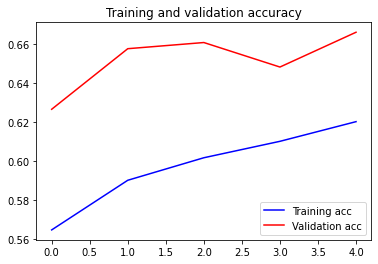

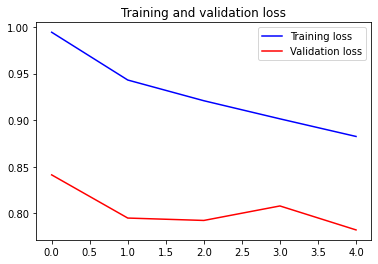

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
model.save("cnn30_yelp_word2vec.h5")
pickle.dump(tokenizer, open("tokenizer_cnn30_yelp_word2vec.pkl", "wb"), protocol=0)

In [0]:
tokenizer = None
with open('tokenizer_cnn30_yelp_word2vec.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [27]:
text = ["the restaurant we went yesterday was awful.\nThe food was bad, the service was bad."]
tokenizer.texts_to_sequences(text)

[[1, 103, 16, 101, 1550, 6, 765, 1, 29, 6, 136, 1, 53, 6, 136]]

In [0]:
def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    
    data = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SENT_LENGTH)
    
    ynew = model.predict(data)
    return ynew

In [29]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))

[[0.07300357 0.11752121 0.2259614  0.32439968 0.25911415]]


In [30]:
text = "the restaurant we went yesterday was awful.\nThe food was bad, the service was bad."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.7077747  0.25173345 0.03458069 0.00340168 0.00250948]]
1


In [31]:
text = "The characters in this novel were great. I immediately started rooting for them to succeed. With a shorter Nov the development of the characters were good. It would have been nice to get more background on them but again, short novel means minimal background."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.03001867 0.10263883 0.32353726 0.3533008  0.19050442]]
4


In [32]:
text = "Good concept but I couldn't get swept away in the story. I didn't care for the characters. Events felt disjointed. I'm not sure if it was the story or the writing style, this one just wasn't for me."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00682528 0.25485566 0.69813526 0.03895595 0.00122789]]
3


In [33]:
text = "So far... the worst book I ever read. Started out alright, but everything went downhill the moment the MC discovered his 'superpowers' and became perhaps the biggest Gary Sue (Male counterpart to the Mary Sue) in all of published fiction."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.59655726 0.31831178 0.05505215 0.01532704 0.01475174]]
1


In [34]:
text = "The book is straight up awful and you can't change mind"
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.36395603 0.3206066  0.16833234 0.08545481 0.06165023]]
1


Text(0.5, 1.0, 'Dataset labels distribuition')

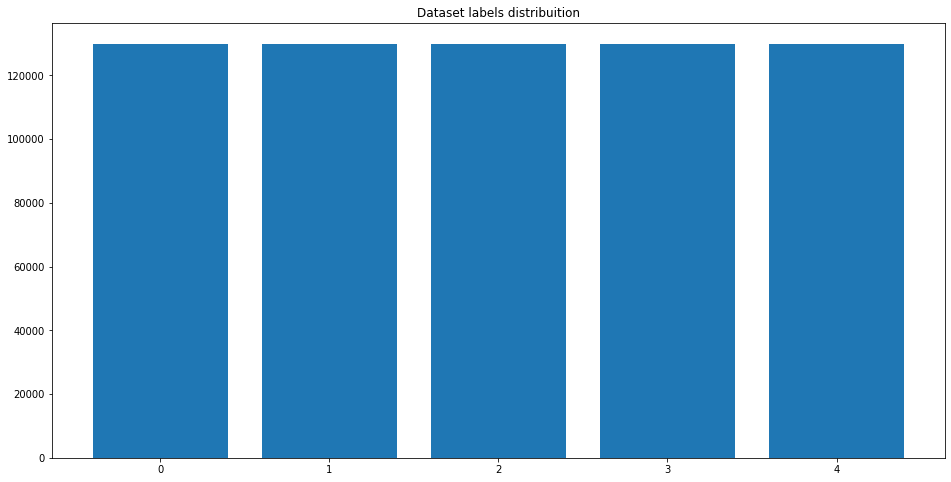

In [35]:
target_cnt = Counter(df_train.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
label_names = ['0', '1', '2', '3', '4']
np.asarray(label_names)

array(['0', '1', '2', '3', '4'], dtype='<U1')

Normalized confusion matrix


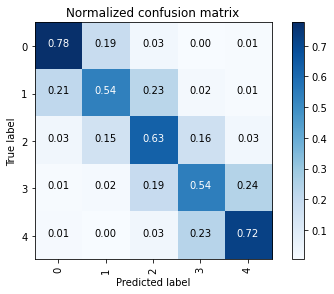

In [39]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
label_names = ['0', '1', '2', '3', '4']
plot_confusion_matrix(conf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

In [40]:
from sklearn.metrics import classification_report
label_names = ['0', '1', '2', '3', '4']
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=label_names))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76     10000
           1       0.60      0.54      0.57     10000
           2       0.57      0.63      0.60     10000
           3       0.57      0.54      0.55     10000
           4       0.72      0.72      0.72     10000

    accuracy                           0.64     50000
   macro avg       0.64      0.64      0.64     50000
weighted avg       0.64      0.64      0.64     50000

